In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

# Loading the data

In [2]:
df_players = pd.read_csv('final_data.csv')

In [3]:
df_players.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [4]:
df_players.shape

(10754, 22)

# EDA

In [5]:
### Uniqueness: checking duplicates
df_players.duplicated().sum()

0

In [6]:
### Completeness: checking null values
df_players.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
### Checking accuracy types:  they seem good to me
df_players.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
### i will drop the unnecessary columns like:
#  name
# player name
# encodded position
# winger: we already knoe from the position column

df_players.drop(['name', 'player', 'position_encoded', 'winger'], axis=1, inplace=True)

In [9]:
df_players.shape

(10754, 18)

In [11]:
df_players.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000


In [12]:
df_players.columns

Index(['team', 'position', 'height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value'],
      dtype='object')

In [13]:
### Checking outliers

## first let's separate the categorical features from numerical ones

categorical_features = ['team', 'position']
numerical_features = ['height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value']

In [14]:
## let's the values of each column
# categorical

for i in categorical_features:
    print(df_players[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64


In [15]:
# let's see the numerical 
for x in numerical_features:
    print(df_players[x].value_counts())
    
# we can cut height < 160
# age < 15 and age > 40
# goals <= 1

height
180.000000    744
185.000000    608
175.000000    596
178.000000    594
183.000000    572
188.000000    493
184.000000    458
182.000000    449
181.240353    440
186.000000    423
187.000000    419
176.000000    390
177.000000    372
190.000000    371
173.000000    366
179.000000    359
181.000000    355
170.000000    312
191.000000    272
174.000000    270
189.000000    255
172.000000    254
192.000000    203
193.000000    181
171.000000    169
168.000000    124
194.000000    117
169.000000    107
195.000000     98
167.000000     85
196.000000     68
166.000000     44
165.000000     42
197.000000     31
198.000000     24
163.000000     16
160.000000     15
164.000000     14
199.000000     12
200.000000     12
202.000000      6
162.000000      6
161.000000      3
206.000000      2
204.000000      1
156.000000      1
159.000000      1
Name: count, dtype: int64
age
22.000000    841
23.000000    823
26.000000    812
25.000000    772
24.000000    767
21.000000    715
28.000000    67

In [16]:
df_players = df_players[df_players['height'] >= 160]

In [17]:
df_players.shape

(10752, 18)

In [18]:
df_players = df_players[(df_players['age'] > 15) & (df_players['age'] < 38)]

In [19]:
df_players.shape

(10657, 18)

# Feature Engineering
1. Feature Scaling
2. one hot encoding

In [20]:
# One-hot encoding categorical variables (team and position)
categorical_features = ['team', 'position']
df_players = pd.get_dummies(df_players, columns=categorical_features)


In [21]:
df_players.shape

(10657, 406)

In [22]:
##### let's divide the target to what we want to know later 

p35 = df_players['current_value'].quantile(0.35)
p75 = df_players['current_value'].quantile(0.75)

## now let's divide the value of a player
def player_value(value):
    if value < p35:
        return 'Low Transfer Value'
    elif value < p75:
        return 'Medium Transfer Value'
    else:
        return 'High Transfer Value'

# applying the dividion of players values to the data
df_players['Transfer_Value_Prediction'] = df_players['current_value'].apply(player_value)

# dropping the target
df_players.drop('current_value', axis=1, inplace=True)

print(df_players['Transfer_Value_Prediction'].value_counts())

Transfer_Value_Prediction
Medium Transfer Value    4288
Low Transfer Value       3681
High Transfer Value      2688
Name: count, dtype: int64


In [23]:
# encoding the new column to deal with it later in feature selection
label_encoder = LabelEncoder()
df_players['Transfer_Value_Prediction_Encoded'] = label_encoder.fit_transform(df_players['Transfer_Value_Prediction'])

# Feature Selection

In [24]:
correlation = df_players.corr(numeric_only=True)
print(correlation['Transfer_Value_Prediction_Encoded'].sort_values(ascending=False))

Transfer_Value_Prediction_Encoded    1.000000
age                                  0.107821
team_Mamelodi Sundowns FC            0.043928
team_Fortaleza Esporte Clube         0.042246
team_Fortuna Sittard                 0.040903
                                       ...   
team_Chelsea FC                     -0.073756
award                               -0.147624
minutes played                      -0.243356
appearance                          -0.247946
highest_value                       -0.417796
Name: Transfer_Value_Prediction_Encoded, Length: 406, dtype: float64


In [25]:
# Selecting features based on the encoded numerical target column
correlation = df_players.corr(numeric_only=True)
threshold = 0.20
selected_features = correlation[abs(correlation['Transfer_Value_Prediction_Encoded']) > threshold].index
selected_features = selected_features[selected_features != 'Transfer_Value_Prediction_Encoded']


# Preparing train and test data 


In [30]:
# splitting
X = df_players[selected_features]
y = df_players['Transfer_Value_Prediction_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   shuffle=True,
                                                 random_state=42)

# scaling features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buidling the Model

In [31]:
# SVM model its primary objective is to find a hyperplane in an N-dimensional space (N being the number of features) that distinctly classifies the data points.
svm_classifier = SVC()

In [32]:
param_grid = {
    'kernel': [
               'rbf','
              ],   # Regularization strength
    'C':[0, 3, 4, 7, 10, 15, 20, 35],
    'gamma': [1,3,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

# Train the model

In [33]:
# Fitting the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 3, 4, 7, 10, 15, 20, 35], 'gamma': [1, 3, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [34]:
# finding the best estimator the model found
grid_search.best_params_


{'C': 15, 'gamma': 6, 'kernel': 'rbf'}

In [35]:
model = grid_search.best_estimator_


# Testing the Model

In [36]:
y_pred = model.predict(X_test_scaled)

# Evaluation

In [37]:
# the benchmark model
base_model = round(df_players['Transfer_Value_Prediction_Encoded'].value_counts()[1]/df_players.shape[0]*100, 2)
base_model # 34 is a too bit low

34.54

In [38]:
# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7950281425891182

In [40]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8072727272727273

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[472,   0,  84],
       [ 20, 580, 114],
       [131,  88, 643]], dtype=int64)

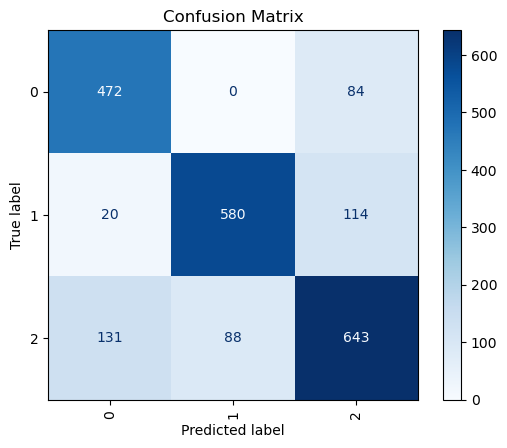

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# 2. Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.80


In [44]:
# 3. Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.80


In [45]:
# 4. F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.80


In [46]:
print(classification_report(y_test,
                      y_pred,
                      labels=list(model.classes_)))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       556
           1       0.87      0.81      0.84       714
           2       0.76      0.75      0.76       862

    accuracy                           0.80      2132
   macro avg       0.80      0.80      0.80      2132
weighted avg       0.80      0.80      0.80      2132

